# BiLSTM
- https://wikidocs.net/94748

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import urllib.request
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime
import csv
import requests
from collections import Counter

import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


In [2]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 7.05 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 37.1 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2024-02-01 03:50:03--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response.

In [3]:
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 불러오기

In [4]:
# 데이터셋 1, 2중 하나 사용
# merged_df = pd.read_csv('/content/drive/MyDrive/CUAI 컨퍼런스/data/merged_df.csv')
merged_df = pd.read_csv('/content/drive/MyDrive/CUAI 컨퍼런스/data/merged_df(감정 분류).csv')[['content', 'label']]

In [5]:
# everytime = pd.read_excel('/content/drive/MyDrive/CUAI 컨퍼런스/안 쓰는 data(일단 저장)/everytime_depression.xlsx')
# everytime['content'] = everytime['title'] + ' ' + everytime['content']

test_data = pd.read_csv('/content/drive/MyDrive/CUAI 컨퍼런스/data/test_data.csv')
test_data['content'] = test_data['title'] + ' ' + test_data['content']

### 전처리

#### 불용어 처리
- 불용어 리스트는 https://www.ranks.nl/stopwords/korean 에서 가져옴

In [6]:
# # 문자열 아닌 데이터 모두 제거
merged_df['content'] = [content for content in merged_df['content'] if type(content) is str]

In [7]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [8]:
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','것','이다','게','에서','거','로','수','에게','요']

In [9]:
pip install konlpy

In [10]:
from konlpy.tag import Okt
from tqdm import tqdm

# KoNLPy의 Okt 형태소 분석기를 사용하여 불용어 제거
okt = Okt()

def remove_stopwords(text):
    words = okt.pos(text, stem=False)  # 형태소 분석, (stem=True -> 기본형?으로 나옴)
    filtered_words = [word for word, pos in words if word not in stopwords]  # 불용어 제거
    return ' '.join(filtered_words)


# 'content' 열에 있는 각 텍스트에 대해 불용어 제거 수행
tqdm.pandas()
merged_df['content'] = merged_df['content'].progress_apply(remove_stopwords)

100%|██████████| 45999/45999 [01:40<00:00, 457.32it/s]


#### 텍스트 정규화

In [11]:
import re
from tqdm import tqdm

def text_normalization(text):
    # 소문자 변환
    text = text.lower()

    # 숫자 제거
    text = re.sub(r'\d+', '', text)

    # 특수문자 제거
    text = re.sub(r'[^\w\s]', '', text)

    return text

tqdm.pandas()
merged_df['content'] = merged_df['content'].progress_apply(text_normalization)

100%|██████████| 45999/45999 [00:00<00:00, 85273.59it/s]


#### 반복 표현 제거(ex. ㅋㅋㅋㅋㅋㅋ,ㅎㅎㅎㅎㅎ)

In [12]:
def replace_repeated_chars(text):
    # 두 번 이상 반복되는 글자(예: ㅋㅋㅋ, ㅎㅎㅎ)를 찾아 해당 글자의 두 번 반복으로 치환
    pattern = re.compile(r'(.)\1{1,}', re.DOTALL)

    # 정규식에 맞게 두 번 이상 반복되는 글자를 찾아 치환
    text = pattern.sub(r'\1\1', text)

    return text

# 'content' 열에 있는 각 텍스트에 대해 두 번 이상 반복되는 글자를 찾아 치환
tqdm.pandas()
merged_df['content'] = merged_df['content'].progress_apply(replace_repeated_chars)

100%|██████████| 45999/45999 [00:00<00:00, 91416.28it/s]


In [13]:
df_length = merged_df['content'].astype(str).apply(len)
print('글 길이 최댓값: {}'.format(np.max(df_length)))
print('글 길이 최솟값: {}'.format(np.min(df_length)))
print('글 길이 평균값: {:.2f}'.format(np.mean(df_length)))
print('글 길이 중간값: {}'.format(np.median(df_length)))
print('글 길이 제1사분위: {}'.format(np.percentile(df_length,25)))
print('글 길이 제3사분위: {}'.format(np.percentile(df_length,75)))

글 길이 최댓값: 125
글 길이 최솟값: 0
글 길이 평균값: 28.74
글 길이 중간값: 28.0
글 길이 제1사분위: 18.0
글 길이 제3사분위: 38.0


In [14]:
merged_df = merged_df[merged_df['content'].str.len() > 5]
merged_df.shape

(45715, 2)

In [15]:
df_length = merged_df['content'].astype(str).apply(len)
print('글 길이 최댓값: {}'.format(np.max(df_length)))
print('글 길이 최솟값: {}'.format(np.min(df_length)))
print('글 길이 평균값: {:.2f}'.format(np.mean(df_length)))
print('글 길이 중간값: {}'.format(np.median(df_length)))
print('글 길이 제1사분위: {}'.format(np.percentile(df_length,25)))
print('글 길이 제3사분위: {}'.format(np.percentile(df_length,75)))

글 길이 최댓값: 125
글 길이 최솟값: 6
글 길이 평균값: 28.89
글 길이 중간값: 28.0
글 길이 제1사분위: 18.0
글 길이 제3사분위: 38.0


In [16]:
test_data['content'] = test_data['content'].progress_apply(remove_stopwords)
test_data['content'] = test_data['content'].progress_apply(text_normalization)
test_data['content'] = test_data['content'].progress_apply(replace_repeated_chars)

100%|██████████| 390/390 [00:00<00:00, 98227.26it/s]


In [17]:
df_length = test_data['content'].astype(str).apply(len)
print('글 길이 최댓값: {}'.format(np.max(df_length)))
print('글 길이 최솟값: {}'.format(np.min(df_length)))
print('글 길이 평균값: {:.2f}'.format(np.mean(df_length)))
print('글 길이 중간값: {}'.format(np.median(df_length)))
print('글 길이 제1사분위: {}'.format(np.percentile(df_length,25)))
print('글 길이 제3사분위: {}'.format(np.percentile(df_length,75)))

글 길이 최댓값: 213
글 길이 최솟값: 4
글 길이 평균값: 66.86
글 길이 중간값: 47.0
글 길이 제1사분위: 27.0
글 길이 제3사분위: 96.75


2) 훈련 데이터와 테스트 데이터 분리하기

In [18]:
train_data = merged_df
# train_data, test_data = train_test_split(merged_df, test_size = 0.2, random_state = 42)
# print('훈련용 데이터 개수 :', len(train_data))
# print('테스트용 데이터 개수 :', len(test_data))

단어와 길이 분포 확인하기

In [19]:
non_depression_words = np.hstack(train_data[train_data.label == 0]['content'].values)
depression_words = np.hstack(train_data[train_data.label == 1]['content'].values)

In [20]:
non_depression_word_count = Counter(non_depression_words)
print(non_depression_word_count.most_common(20))

[('감사합니다 ', 27), ('축하 드려요 ', 5), ('항상 응원 합니다 ', 4), ('생일 축하 합니다 ', 4), ('생일 축하 해 요 ', 4), ('대박 이다 ', 3), ('아이고 의미 없다 ', 3), ('유재석 오라버니 해피투게더 봤어요', 3), ('축하 해요 ', 3), ('안녕하세요 ', 3), ('축하 드립니다 ', 3), ('항상 감사합니다', 3), ('축하 합니다 ', 3), ('특검 화이팅 ', 3), ('항상 고마워요', 3), ('감사 드립니다', 3), ('나 몇 년 동안 신입 으로만 다니던 회사 에서 정식 사원 으로 승진 했어 ', 2), ('나 앞 으로 건강 관리 최선 할 거야  돈 걱정 없어서 많은 투자 할 수 있어 ', 2), ('나 예전 부터 세계 여행 내 꿈이었어  만성 질환 치료 만 된다면 내 꿈 이룰 거야 ', 2), ('선생님 덕분 날 괴롭히던 애 오해 풀 잘 지낼 수 있게 됐어  정말 감사 드려 ', 2)]


In [21]:
depression_word_count = Counter(depression_words)
print(depression_word_count.most_common(20))

[('나 지금 너무 비관 적 이야 ', 3), ('너무 힘들어 ', 3), ('너무 힘들어요', 3), ('방탈 죄송합니다 ㅠㅠ', 2), ('애 날 괴롭히고 있어  그런데 무서워서 저항 못 하겠어 ', 2), ('안녕하세요 ㅠㅠ', 2), ('죄송합니다 ', 2), ('연애 오랜 기간 했는데 상대방 한테 배신 당 거 같아 ', 2), ('내 조상 중 에서는 뇌 질환 때문 오래 사신 분 없대  삶 남지 않은 것 같아 너무 허무해 ', 2), ('나를 괴롭힌 친구 갑자기 웃으면서 말 거 데 불안했어 ', 2), ('손주 내 건강 에는 관심 없는지 안부 전화 통 없어서 서운해 ', 2), ('올해 휴가 번 못 가고 일 년 지났네 ', 2), ('요즘 너무 힘들어 ', 2), ('내 상사 왜 이렇게 말 심하게 할까  나 상사 복 없나 봐 ', 2), ('가족 관계 염세 적 이야 ', 2), ('아내 나 몰래 식당 에서 일 하고 있었 더 라고  아마도 자존심 강한 내게 말 하기 힘들었나 봐 ', 2), ('학교 에서 괴롭힘 당했는데 오히려 부모님 께선 나를 혼내셨어 ', 2), ('언제 죽을지 몰라 불안해 할 바 에는 빨리 죽는 나을 것 같아 ', 2), ('모두 나 에게 대가 바라고 잘 해준다는 생각 들어서 우울해 ', 2), ('마음 답답합니다 ', 2)]


우울 문장의 평균 길이 : 32.75340268747291
비우울 문장의 평균 길이 : 24.95146831530139


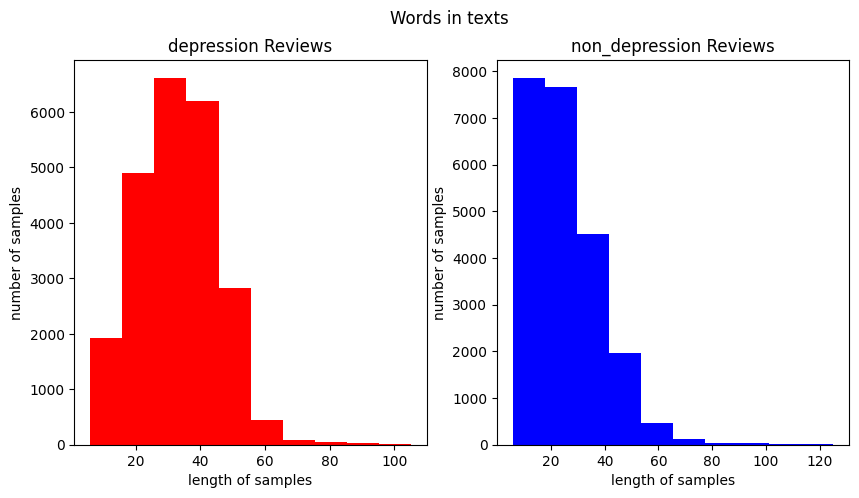

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['content'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('depression Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('우울 문장의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['content'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('non_depression Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('비우울 문장의 평균 길이 :', np.mean(text_len))
plt.show()

In [23]:
X_train = train_data['content'].values
y_train = train_data['label'].values
X_test= test_data['content'].values
y_test = test_data['label'].values

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40092
등장 빈도가 2번 이하인 희귀 단어의 수: 27956
단어 집합에서 희귀 단어의 비율: 69.72962186969968
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.003171464461925


In [26]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12138


In [27]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

패딩

최대 길이 : 39
평균 길이 : 9.15966313026359


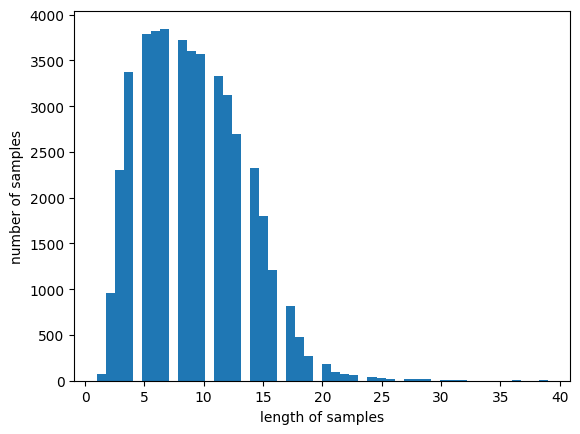

In [28]:
print('최대 길이 :',max(len(review) for review in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [30]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 100.0


In [31]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

BiLSTM으로 스팀 리뷰 감성 분류하기

In [32]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
143/143 [==============================] - ETA: 0s - loss: 0.5260 - acc: 0.7287
Epoch 1: val_acc improved from -inf to 0.86602, saving model to best_model.h5
143/143 [==============================] - 26s 131ms/step - loss: 0.5260 - acc: 0.7287 - val_loss: 0.4077 - val_acc: 0.8660
Epoch 2/15
  1/143 [..............................] - ETA: 3s - loss: 0.3045 - acc: 0.8906

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - ETA: 0s - loss: 0.3207 - acc: 0.8638
Epoch 2: val_acc improved from 0.86602 to 0.87750, saving model to best_model.h5
143/143 [==============================] - 6s 39ms/step - loss: 0.3207 - acc: 0.8638 - val_loss: 0.3516 - val_acc: 0.8775
Epoch 3/15
143/143 [==============================] - ETA: 0s - loss: 0.2599 - acc: 0.8946
Epoch 3: val_acc did not improve from 0.87750
143/143 [==============================] - 4s 30ms/step - loss: 0.2599 - acc: 0.8946 - val_loss: 0.3374 - val_acc: 0.8753
Epoch 4/15
140/143 [============================>.] - ETA: 0s - loss: 0.2314 - acc: 0.9085
Epoch 4: val_acc did not improve from 0.87750
143/143 [==============================] - 5s 33ms/step - loss: 0.2313 - acc: 0.9084 - val_loss: 0.3434 - val_acc: 0.8654
Epoch 5/15
140/143 [============================>.] - ETA: 0s - loss: 0.2124 - acc: 0.9167
Epoch 5: val_acc did not improve from 0.87750
143/143 [==============================] - 3s 20ms/step - loss

### 검증

In [35]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

13/13 [==============================] - 1s 8ms/step - loss: 0.5220 - acc: 0.7923
테스트 정확도: 0.7923


### 에브리 타임 데이터에 대해 검증

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_sentiment_model(df_content, df_label):

    # 예측
    scores = loaded_model.predict(df_content)
    predictions = (scores > 0.5).astype(int)  # 이진 분류일 때, 0.5를 기준으로 이상이면 1, 이하는 0으로 변환

    # 평가 지표 계산
    accuracy = accuracy_score(df_label, predictions)
    precision = precision_score(df_label, predictions)
    recall = recall_score(df_label, predictions)
    f1 = f1_score(df_label, predictions)

    print("accuracy: {:.4f}".format(accuracy))
    print("recall: {:.4f}".format(recall))
    print("precision: {:.4f}".format(precision))
    print("F1 Score: {:.4f}".format(f1))

evaluate_sentiment_model(X_test, y_test)

13/13 [==============================] - 0s 5ms/step
accuracy: 0.7923
recall: 0.7665
precision: 0.8118
F1 Score: 0.7885


### 예측

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 비우울 문장입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 우울 문장입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('우울하다')

1/1 [==============================] - 0s 114ms/step
75.42% 확률로 긍정 리뷰입니다.
